# Social network Graph Link Prediction - Facebook Challenge

## Problem statement:
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph).

## Data Overview
Taken data from facebook's recruting challenge on kaggle
https://www.kaggle.com/c/FacebookRecruiting

data contains two columns soutce and destination eac edge in graph.
  - Data columns (total 2 columns):
  - source_node     int64
  - destination_node     int64


## Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed bak, page rank, katz score, adar index, some svd features of adj matrix, some weight features etc. and trained ml model based on these features to predict link.
- Some reference papers anda videos: 
  https://www.cs.cornell.edu/home/kleinber/linkpred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

## Business objectives and constraints:
- No low-latency requirement.
- Probability of prediction is useful to recommend highest probability links.

## Performace metric for supervised learning:
- Both precision and recall is important so F1 score is good choice.
- Confusion matrix

In [0]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')

import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams #size of plots
from sklearn.cluster import MiniBatchKMeans, KMeans #Clustering
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb

from scipy.sparse.linalg import svds, eigs
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [0]:
data_path = '/content/drive/My Drive/Case_Study/fb/data/'

In [0]:
# reading graph
if not os.path.isfile(data_path+'data/after_eda/train_woheader.csv'):
  traincsv = pd.read_csv(data_path+'data/train.csv')
  print(traincsv[traincsv.isna().any(1)])
  print(traincsv.info())
  print("Number of duplicate entries: ", sum(traincsv.duplicated()))
  traincsv.to_csv(data_path+'data/after_eda/train_woheader.csv', header=False, index=False)
  print("saved the graph into file")
else:
  g = nx.read_edgelist(data_path+'data/after_eda/train_woheader.csv', delimiter=',', create_using=nx.DiGraph(), nodetype= int)
  print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


**Displaying a sub graph**

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


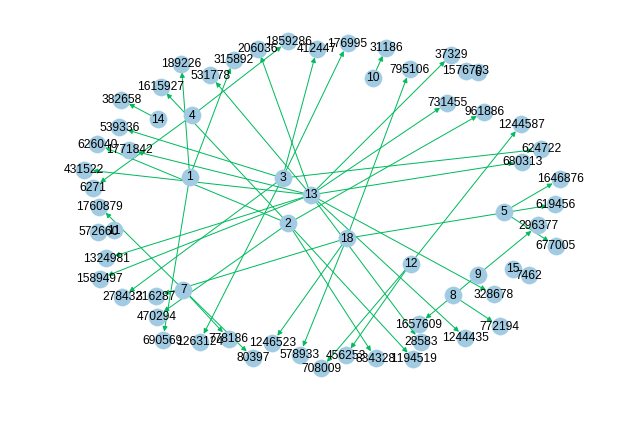

In [23]:
if not os.path.isfile(data_path+'train_woheader_sample.csv'):
    pd.read_csv(data_path+'data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

## 1. Exploratory Data Analysis

In [0]:
# No of Unique persons
print("The number of unique persons", len(g.nodes()))

The number of unique persons 1862220


### 1.1 No of followers for each person

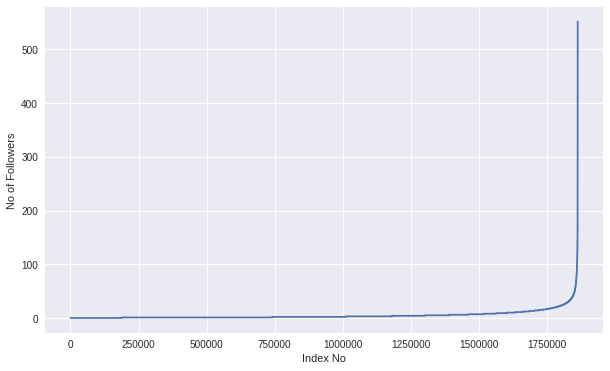

In [0]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

**Observations**
- Mojority of the users have less number of followers.
- There is a very small subset of users who have more than 500 followers.

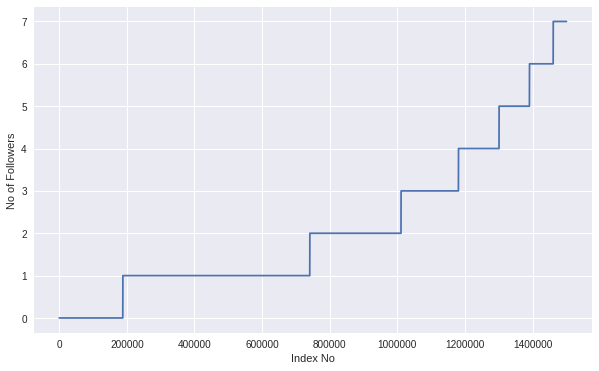

In [0]:
#zoom in
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist[0: 1500000])
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

**Observations**
- Almost 1.4 Million users have followers in the range (0, 7).

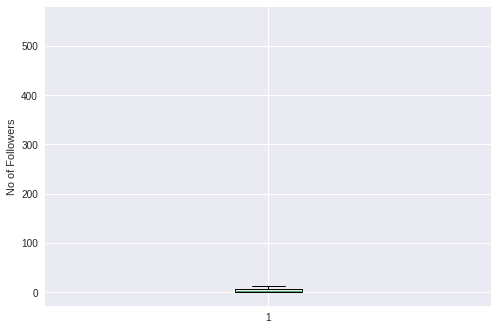

In [0]:
plt.boxplot(indegree_dist)
plt.ylabel('No of Followers')
plt.show()

**Observations**
- Most of the users have less number of followers.

In [0]:
# 90-100 percentile
for i in range(0, 11):
  print(90+i, 'percentile value is', np.percentile(indegree_dist, 90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


**Observations**
- 99% of users having followers of 40 only.

In [0]:
# 99-100 percentile
for i in range(10, 110, 10):
  print(99+(i/100), 'percentile value is', np.percentile(indegree_dist, 99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


**Observations**
- 99.9% of users have followers less than 112.

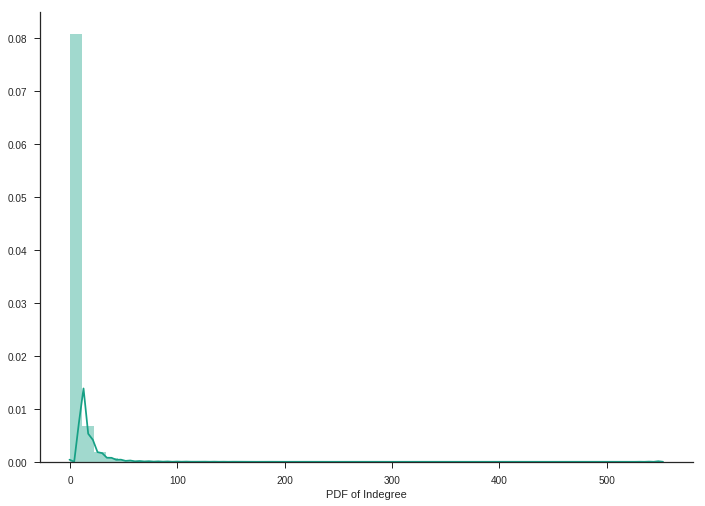

In [0]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
plt.show()

**Observations**
- Most users have less followers. Very few users with more than 40 followers. 

### 1.2 No of people each person is following

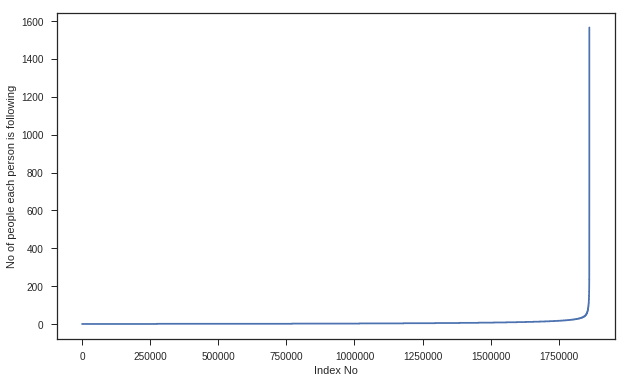

In [0]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following')
plt.show()

**Observations**
- Most users follow fewer people. Small number of users which follows more people.

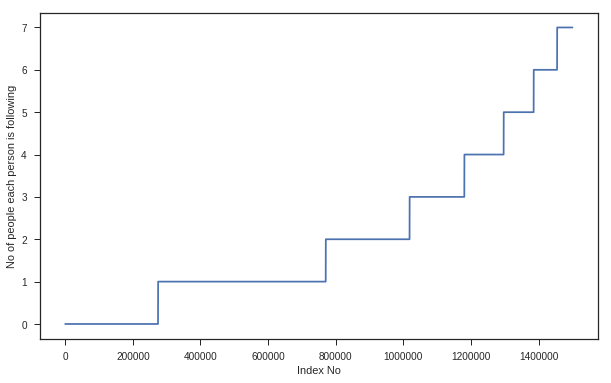

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No of people each person is following')
plt.show()

**Observations**
- Almost 1.4 Million users are following people in the range (0, 7).

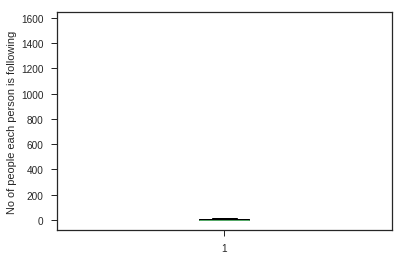

In [0]:
plt.boxplot(outdegree_dist)
plt.ylabel('No of people each person is following')
plt.show()

**Observations**
- Most users follow less number of people.

In [0]:
# 90-100 percentile 
for i in range(0, 11):
  print(90+i, 'percentile value is', np.percentile(outdegree_dist, 90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


**Observations**
- 99% of users are follwing less than 40 people.

In [0]:
#90-100 percentile
for i in range(10, 110, 10):
  print(99+(i/100), 'percentile value is', np.percentile(outdegree_dist, 99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


**Observations**
- 99.9% of users are following less than 123 people.Only 0.1% users are following people more than that.

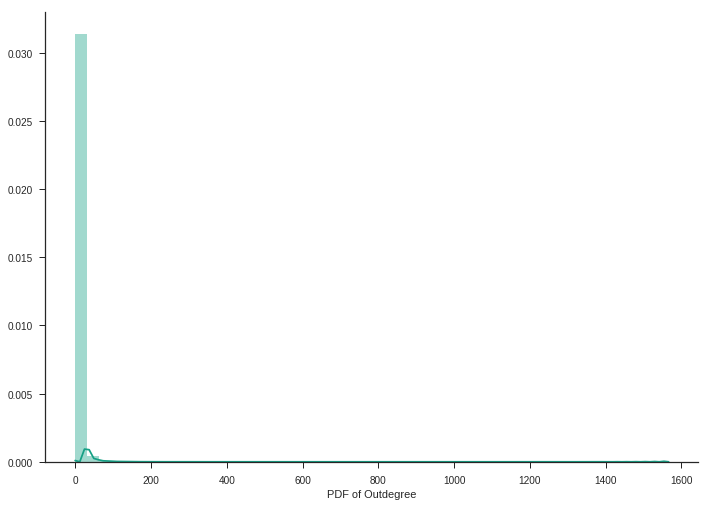

In [0]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()
plt.show()

**Observations**
- Most of the users are following very less people.

In [0]:
print('No of persons those are not following anyone are', sum(np.array(outdegree_dist)==0), 'and % is',
     sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [0]:
print('No of persons having zero followers are', sum(np.array(indegree_dist)==0), 'and % is',
     sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

No of persons having zero followers are 188043 and % is 10.097786512871734


In [0]:
count = 0
for i in g.nodes():
  if len(list(g.predecessors(i)))==0:
    if len(list(g.successors(i)))==0:
      count+=1
print('No of persons those are not following anyone and also not having any followers are: ', count)

No of persons those are not following anyone and also not having any followers are:  0


### 1.3 Both followers + following

In [0]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

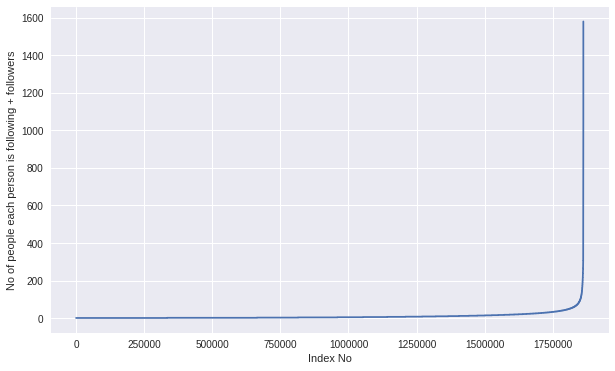

In [0]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10, 6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following + followers')
plt.show()

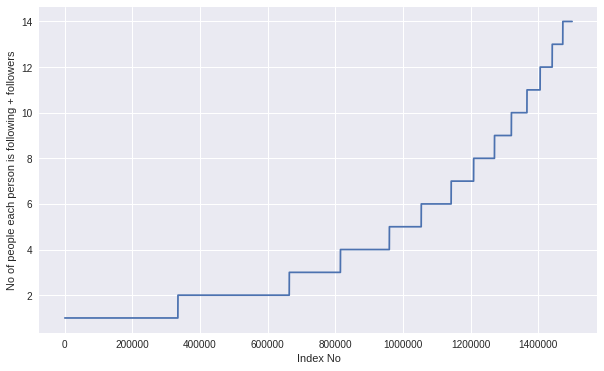

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(in_out_degree_sort[:1500000])
plt.xlabel('Index No')
plt.ylabel('No of people each person is following + followers')
plt.show()

In [0]:
# 90-100 percentile 
for i in range(0, 11):
  print(90+i, 'percentile value is', np.percentile(in_out_degree_sort, 90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [0]:
# 99-100 percentile 
for i in range(10, 110, 10):
  print(99+(i/100), 'percentile value is', np.percentile(in_out_degree_sort, 99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [0]:
print('Min of no of followers + following is', in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()), 'persons having minimum no of followers + following')

Min of no of followers + following is 1
334291 persons having minimum no of followers + following


In [0]:
print('Max of no of followers + following is', in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()), 'persons having maximum no of followers + following')

Max of no of followers + following is 1579
1 persons having maximum no of followers + following


In [0]:
print('No of persons having followers + following less than 10 are', np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [0]:
print('No of weakly connected components', len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
  if len(i)==2:
    count+=1
print('weakly connected components with 2 nodes', count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195


## 2. Posing a problem as classification problem

### 2.1 Generating some edges which are not present in graph for supervised learning

Generated Bad links from graph which are not in graph and whose shortest path is greater than 2.

In [0]:
%%time 
# generating bad edges from given graph
import random
if not os.path.isfile(data_path+'data/after_eda/missing_edges_final.p'):
  # getting all set of edges
  r = csv.reader(open(data_path+'data/after_eda/train_woheader.csv', 'r'))
  edges = dict()
  for edge in r:
    edges[(edge[0], edge[1])] = 1
    
  missing_edges = set([])
  while (len(missing_edges)<9437519):
    a = random.randint(1, 1862220)
    b = random.randint(1, 1862220)
    tmp = edges.get((a, b), -1)
    if tmp == -1 and a!=b:
      try:
        if nx.shortest_path_length(g, source=a, target=b) > 2:
          missing_edges.add((a, b))
        else:
          continue
      except:
        missing_edges.add((a,b))
    else:
      continue
  pickle.dump(missing_edges, open(data_path+'data/after_eda/missing_edges_final.p', 'wb'))
else:
  missing_edges = pickle.load(open(data_path+'data/after_eda/missing_edges_final.p', 'rb'))

CPU times: user 2.73 s, sys: 1.21 s, total: 3.94 s
Wall time: 6.04 s


In [0]:
len(missing_edges)

9437519

### 2.2 Training and Test data split

Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and Test data.

In [0]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile(data_path+'data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile(data_path+'data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv(data_path+'data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv(data_path+'data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv(data_path+'data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv(data_path+'data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv(data_path+'data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

In [0]:
if (os.path.isfile(data_path+'data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile(data_path+'data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist(data_path+'data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist(data_path+'data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

we have cold start problem here

In [0]:
#final train and test data sets
if (not os.path.isfile(data_path+'data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile(data_path+'data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile(data_path+'data/train_y.csv')) and \
(not os.path.isfile(data_path+'data/test_y.csv')) and \
(os.path.isfile(data_path+'data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile(data_path+'data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile(data_path+'data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile(data_path+'data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv(data_path+'data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv(data_path+'data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv(data_path+'data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv(data_path+'data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv(data_path+'data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv(data_path+'data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

In [168]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


## 3. Similarity measures

In [5]:
if os.path.isfile(data_path+'data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist(data_path+'data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


## 3.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [0]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [0]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [0]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [0]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [0]:
print(jaccard_for_followers(273084,470294))

0.0


In [0]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


### 3.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{SQRT(|X|\cdot|Y|)} 
\end{equation}

In [0]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [0]:
print(cosine_for_followees(273084,1505602))

0.0


In [0]:
print(cosine_for_followees(273084,1635354))

0


In [0]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [0]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [0]:
print(cosine_for_followers(669354,1635354))

0


## 4. Ranking Measures

### 4.1 Page Ranking 


https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='https://upload.wikimedia.org/wikipedia/en/thumb/8/8b/PageRanks-Example.jpg/1200px-PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open(data_path+'data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open(data_path+'data/fea_sample/page_rank.p','rb'))

In [0]:
print('min', pr[min(pr, key=pr.get)])
print('max', pr[max(pr, key=pr.get)])
print('mean', float(sum(pr.values()))/ len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [0]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


## 5. Other Graph Features

### 5.1 Shortest path:

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path.

In [0]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [0]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [0]:
#testing
compute_shortest_path_length(669354,1635354)

-1

### 5.2 Checking for same community

In [0]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [0]:
belongs_to_same_wcc(861, 1659750)

0

In [0]:
belongs_to_same_wcc(669354,1635354)

0

### 5.3 Adamic/Adar Index:

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [0]:
def calc_adar_in(a, b):
  sum=0
  try:
    n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
    if len(n) != 0:
      for i in n:
        sum = sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
      return sum
    else:
      return 0
  except:
    return 0

In [7]:
calc_adar_in(1,189226)

0

In [8]:
calc_adar_in(669354,1635354)

0

### 5.4 Is person was following back:

In [0]:
def follows_back(a, b):
  if train_graph.has_edge(b, a):
    return 1
  else:
    return 0

In [10]:
follows_back(1,189226)

1

In [11]:
follows_back(669354,1635354)

0

### 5.5 Katz Centrality


https://en.wikipedia.org/wiki/Katz_centrality
​
https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.
​
The parameter $$\beta$$ controls the initial centrality and 
​
$$\alpha < \frac{1}{\la

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open(data_path+'data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open(data_path+'data/fea_sample/katz.p','rb'))

In [13]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [14]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


### 5.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open(data_path+'data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open(data_path+'data/fea_sample/hits.p','rb'))

In [17]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


## 6. Featurization 

### 6.1 Reading a sample of Data from both train and test

In [0]:
import random
if os.path.isfile(data_path+'data/after_eda/train_after_eda.csv'):
    filename = data_path+"data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [0]:
if os.path.isfile(data_path+'data/after_eda/train_after_eda.csv'):
    filename = data_path+"data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [20]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [22]:
df_final_train = pd.read_csv(data_path+'data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv(data_path+'data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1076063,58393,1


In [23]:
df_final_test = pd.read_csv(data_path+'data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv(data_path+'data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,805597,378324,1


### 6.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

    #mapping cosine followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping cosine followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore(data_path+'data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf(data_path+'data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf(data_path+'data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

### 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore(data_path+'data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf(data_path+'data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf(data_path+'data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

### 6.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

In [0]:
#weight for source and destination of each link
import tqdm

Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [0]:
if not os.path.isfile(data_path+'data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore(data_path+'data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf(data_path+'data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf(data_path+'data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

### 6.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [0]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [0]:
#for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [0]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [93]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [0]:
if not os.path.isfile(data_path+'data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore(data_path+'data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

### 6.6 Preferential Attachement

The Preferential Attachment Model is an attempt to create a blueprint of the essential structure of many social networks. It assumes that individuals (nodes) with many connections (a high degree) get more new connections (neighbors) than individuals with fewer connections. In other words, if you already have many friends, you are going to meet more new people that someone with fewer friends.

To calculate the preferential attachment score, one simply multiplies the number of connections the individuals of interest have with each other.

<img src="https://cdn-images-1.medium.com/max/1000/1*RugBO5XtJRMaGwWuZCOliA.png">

As you can see, both Liz and Jack have three neighbors. Thus, their preferential attachment score is 3*3=9.

__source: https://towardsdatascience.com/predicting-friendship-a82bc7bbdf11 __

In [0]:
#for followees
def preferential_attachment_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))
    except:
        return 0
      
    return sim

In [67]:
preferential_attachment_followees(1,2)

10

In [0]:
#for followers
def preferential_attachment_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b)))
    except:
        return 0
      
    return sim

In [71]:
preferential_attachment_followers(1,2)

9

In [0]:
# mapping preferential attachment followers to train and test data.
df_final_train['pa_followers'] = df_final_train.apply(lambda row:
                                            preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['pa_followers'] = df_final_test.apply(lambda row:
                                            preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)

# mapping preferential attachment followees to train and test data.
df_final_train['pa_followees'] = df_final_train.apply(lambda row:
                                            preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['pa_followees'] = df_final_test.apply(lambda row:
                                            preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)

### 6.7 Feature `svd_dot`

Dot product between source node svd and destination node svd features.

In [0]:
def calculate_svd_dot(a, b):
  
  a_svd = np.array(svd(a, U)) # source node svd
  b_svd = np.array(svd(b, U)) # destination node svd

  return a_svd.dot(b_svd)

In [131]:
calculate_svd_dot(273084, 1505602)

1.114950762753286e-11

In [0]:
#svd_dot for train
df_final_train['svd_dot'] = df_final_train.apply(lambda row:
                                                calculate_svd_dot(row['source_node'], row['destination_node']), axis=1)

#svd_dot for test
df_final_test['svd_dot'] = df_final_test.apply(lambda row:
                                                calculate_svd_dot(row['source_node'], row['destination_node']), axis=1)

In [134]:
df_final_train.head(1)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pa_followers,pa_followees,svd_dot
0,273084,1505602,1,0,0.0,0.0,0.0,6,15,8,...,1.719702e-14,-1.355368e-12,4.675307e-13,0.000001,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114951e-11


## 7. ML Models

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

**Random Forest**

Estimators =  10 Train Score 0.9171651563563983 test Score 0.8856791773557247
Estimators =  50 Train Score 0.9180859522115747 test Score 0.9133190614112412
Estimators =  100 Train Score 0.9191500036583709 test Score 0.914237785699308
Estimators =  250 Train Score 0.9204492034473754 test Score 0.9154817331487772
Estimators =  450 Train Score 0.921399753329013 test Score 0.91638866158914


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

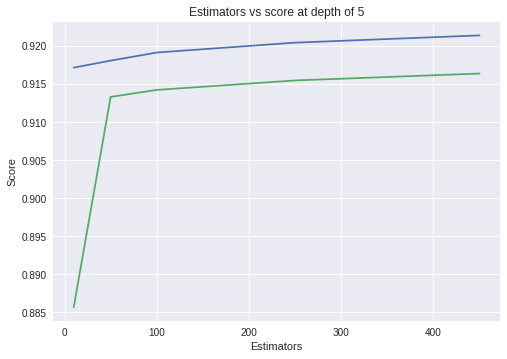

In [154]:
#Random Forest 

from sklearn.ensemble import RandomForestClassifier

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8860290267859012 test Score 0.8648290881140979
depth =  9 Train Score 0.9569167015402202 test Score 0.9231353197950276
depth =  11 Train Score 0.9609976445636323 test Score 0.9246184416353106
depth =  15 Train Score 0.9639495252779355 test Score 0.9265367947153617
depth =  20 Train Score 0.9640834832819951 test Score 0.9264619019492026
depth =  35 Train Score 0.9638279923976787 test Score 0.9264250015815777
depth =  50 Train Score 0.9638279923976787 test Score 0.9264250015815777
depth =  70 Train Score 0.9638279923976787 test Score 0.9264250015815777
depth =  130 Train Score 0.9638279923976787 test Score 0.9264250015815777


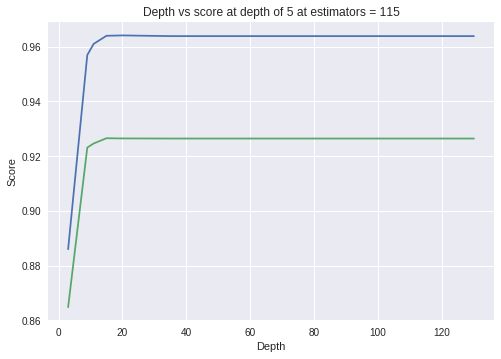

In [155]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [156]:
# Random Search

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96238158 0.9613865  0.96040218 0.96197866 0.96311147]
mean train scores [0.96319749 0.96231491 0.96102571 0.96278682 0.96427442]


In [158]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [0]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [161]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9645626141668358
Test f1 score 0.9266319802835297


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue", as_cmap=True)
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


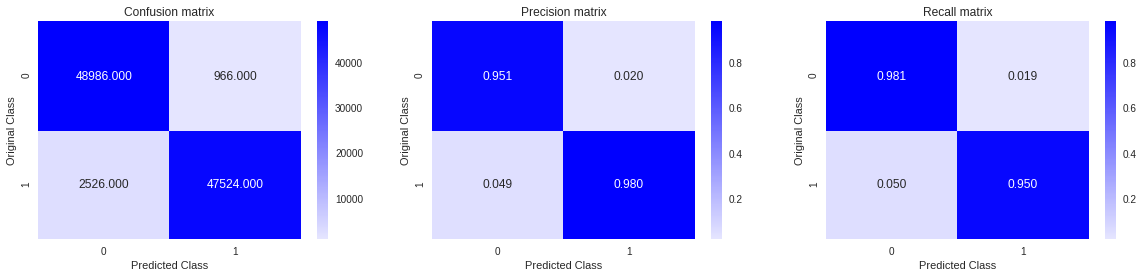

Test confusion_matrix


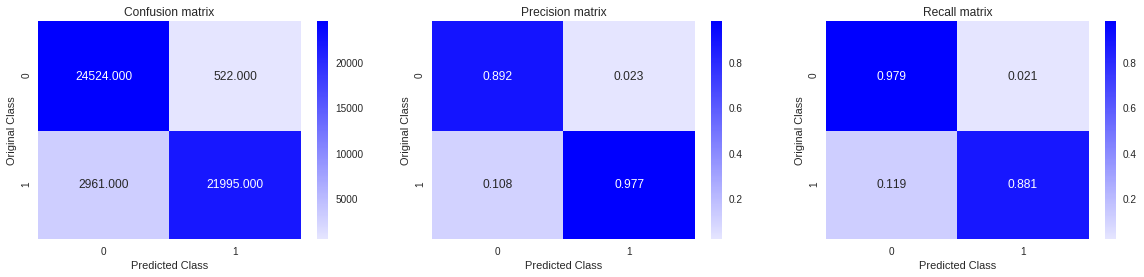

In [162]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

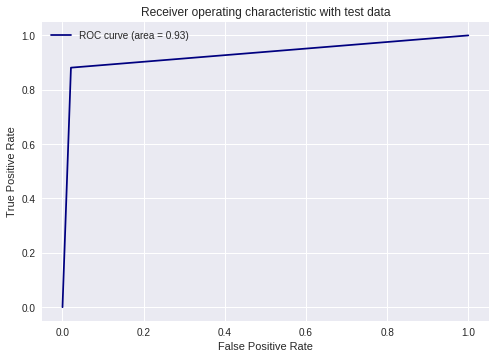

In [163]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

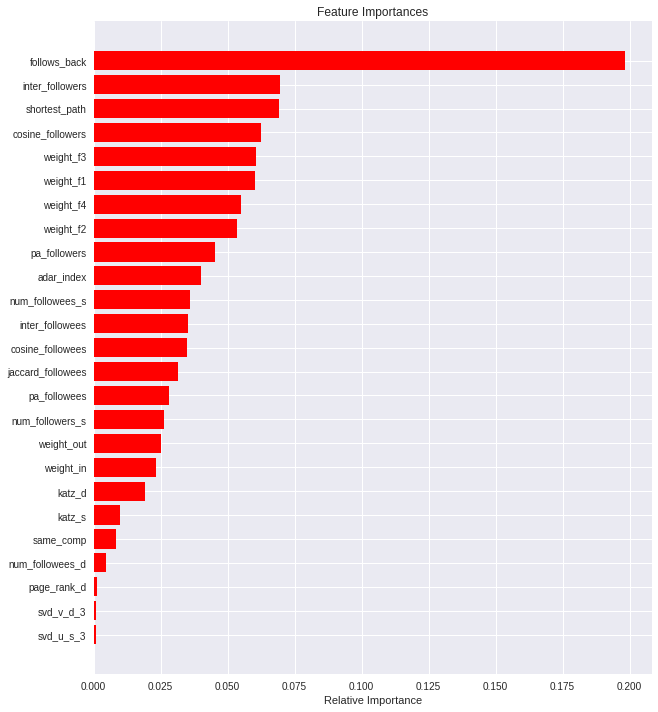

In [164]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**XGBOOST**

Estimators =  10 Train Score 0.9451309527496464 test Score 0.9259376117456511
Estimators =  50 Train Score 0.9714657212803348 test Score 0.9309024766819652
Estimators =  100 Train Score 0.9766152289400455 test Score 0.9297702805798085
Estimators =  250 Train Score 0.9856014489108015 test Score 0.9271163037705787
Estimators =  450 Train Score 0.9938979790186669 test Score 0.9223640944612888


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

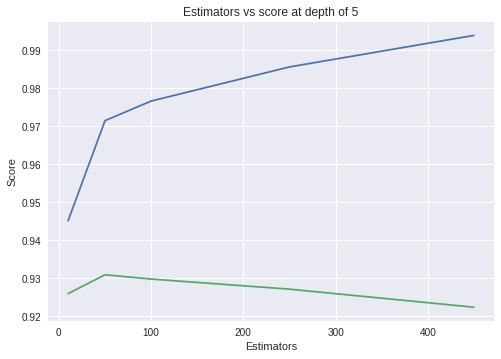

In [138]:
#XGBOOST
import xgboost as xgb
from sklearn.metrics import f1_score

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9740612397916794 test Score 0.9255432240506867
depth =  9 Train Score 0.9894988594454996 test Score 0.9279741946436909
depth =  11 Train Score 0.9960121039658524 test Score 0.9269649797183936
depth =  15 Train Score 0.9998701130016886 test Score 0.9280125527448528
depth =  20 Train Score 1.0 test Score 0.9292565693353378
depth =  35 Train Score 1.0 test Score 0.9295828306559146
depth =  50 Train Score 1.0 test Score 0.929578060857421
depth =  70 Train Score 1.0 test Score 0.929578060857421
depth =  130 Train Score 1.0 test Score 0.929578060857421


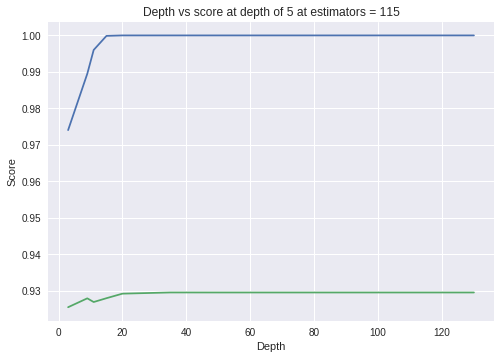

In [166]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = xgb.XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [142]:
# Random Search

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 0.10],
              "min_child_weight": [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
              "gamma": [0, 0.25, 0.5, 1.0]}

clf = xgb.XGBClassifier(random_state=25,n_jobs=-1, verbose=2)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25, n_jobs=-1, verbose=2)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 55.9min finished


mean test scores [0.98052493 0.9796315  0.98031978 0.98102063 0.98055428]
mean train scores [0.99286179 0.98876489 0.99470232 0.99592539 0.99409738]


In [143]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=13, min_child_weight=7.0, missing=None, n_estimators=118,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=2)


In [0]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=13, min_child_weight=7.0, missing=None, n_estimators=118,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=0)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [146]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9955313307817165
Test f1 score 0.9295440587874039


Train confusion_matrix


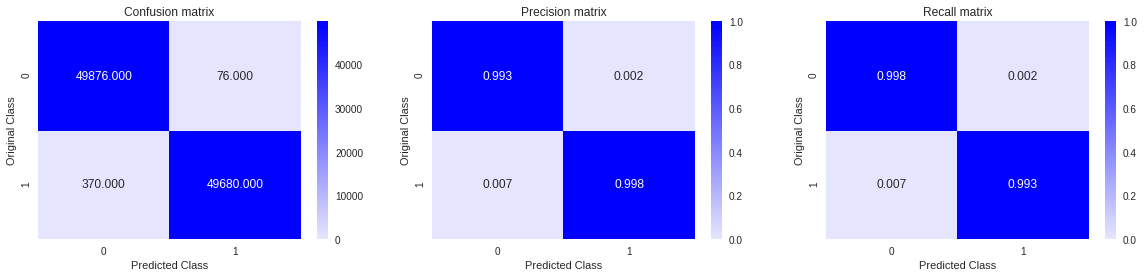

Test confusion_matrix


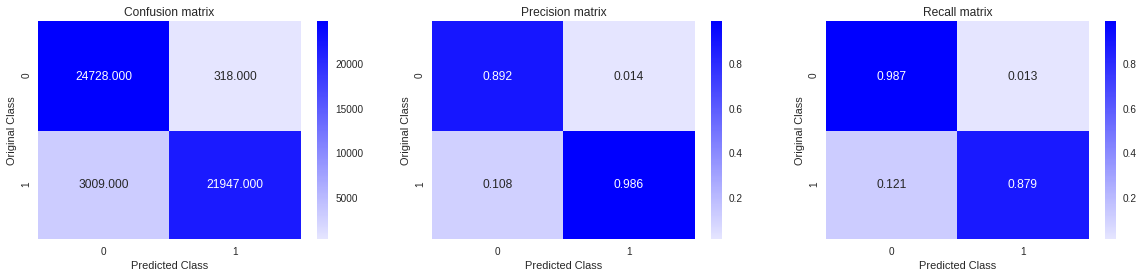

In [150]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

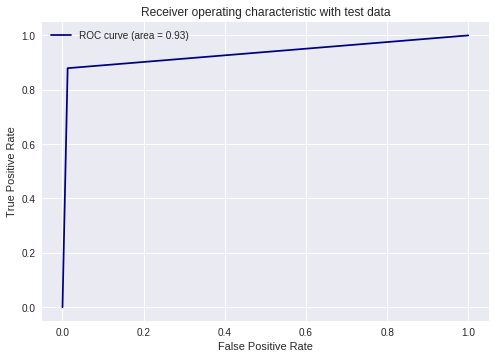

In [151]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

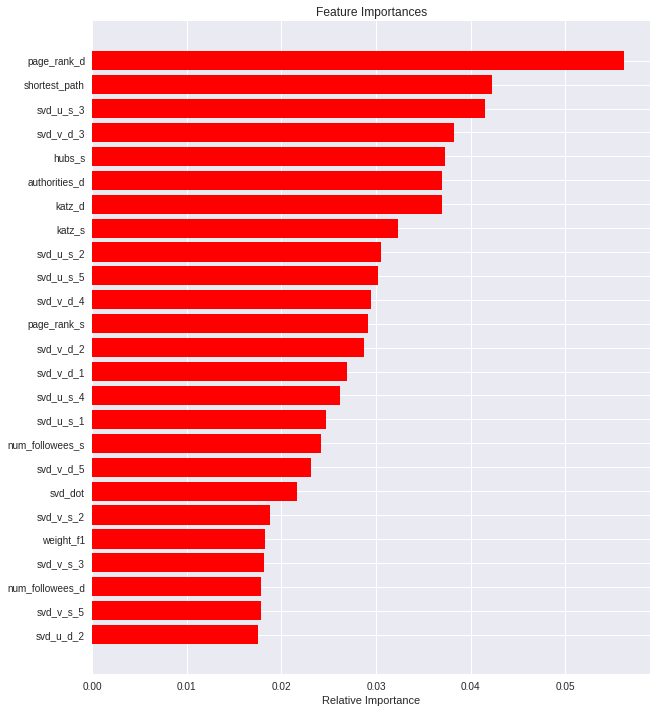

In [152]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 8. Conclusion

In [24]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Model', 'Hyper Parameter', 'F1 Score']

x.add_row(['Random Forest', 'max_depth: 14, \n n_estimators: 121, \n min_samples_leaf: 28, \n min_samples_split: 111', '0.926'])
x.add_row(['XGBOOST', 'max_depth: 13, \n n_estimators: 118, \n learning_rate: 0.1, \n colsample_by_tree: 0.8, \n min_child_weight: 7.0', '0.929'])

print(x)

+---------------+---------------------------+----------+
|     Model     |      Hyper Parameter      | F1 Score |
+---------------+---------------------------+----------+
| Random Forest |      max_depth: 14,       |  0.926   |
|               |     n_estimators: 121,    |          |
|               |   min_samples_leaf: 28,   |          |
|               |   min_samples_split: 111  |          |
|    XGBOOST    |      max_depth: 13,       |  0.929   |
|               |     n_estimators: 118,    |          |
|               |    learning_rate: 0.1,    |          |
|               |  colsample_by_tree: 0.8,  |          |
|               |    min_child_weight: 7.0  |          |
+---------------+---------------------------+----------+


**Steps followed for Assignment: Facebook Friend Recommendation**

- Loaded the dataset and performed basic statistics.
- Loaded the data into Graph(networkx) and performed EDA(followers, following, followers+following).
- Posed the problem into Classification problem, by labelling users with edge as 1 and 0 for no edge between users.
- Train and Test split  of graph data.
- Featurization Techniques applied
  - Jaccard Distance
  - Cosine Distance
  - Page Rank
  - Shortest Path
  - Weakly Connected Components
  - Adamic/Adar Index
  - Follow Back Feature
  - Katz Centrality
  - HITS Score
  - Weight Features
  - SVD(Matrix Factorization) Features
  - Preferential Attachment
  - SVD dot(source & destination node) Feature
- Machine Learning Models
  - Applied Random Forest.
  - Applied XGBOOST.